In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import pointprocesses as ppr

In [41]:
import torch
from torch import nn

In [4]:
torch.manual_seed(1)

In [5]:
import os
import sys

In [6]:
# Add parent dir to interpreter path
nb_dir = os.path.split(os.getcwd())[0]
print("Notebook dir {:}".format(nb_dir))
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

Notebook dir /home/manifold/Documents/etudes/map511-p3a


In [7]:
sys.path

['',
 '/home/manifold/Documents/etudes/map511-p3a/notebooks',
 '/home/manifold/miniconda3/envs/pytorch/lib/python37.zip',
 '/home/manifold/miniconda3/envs/pytorch/lib/python3.7',
 '/home/manifold/miniconda3/envs/pytorch/lib/python3.7/lib-dynload',
 '/home/manifold/miniconda3/envs/pytorch/lib/python3.7/site-packages',
 '/home/manifold/miniconda3/envs/pytorch/lib/python3.7/site-packages/pointprocesses-0.4.0-py3.7-linux-x86_64.egg',
 '/home/manifold/miniconda3/envs/pytorch/lib/python3.7/site-packages/torchvision-0.2.1-py3.7.egg',
 '/home/manifold/miniconda3/envs/pytorch/lib/python3.7/site-packages/IPython/extensions',
 '/home/manifold/.ipython',
 '/home/manifold/Documents/etudes/map511-p3a']

# Synthetic data, Hawkes processes

The standard Hawkes model has an underlying intensity given by
$$
    \lambda_t = \lambda^0_t + \int_0^t g(t-s)\,dN_s
$$
where the function $g \geq 0$ is called the _kernel_.

Here we simulate Hawkes processes with kernel $g(t) = \alpha\exp(-\delta t)$.

In [8]:
def intensity_function_(t, lam0, alpha, beta, history):
    return lam0 + np.sum(alpha*beta*np.exp(-beta*(t - history))*(t >= history), axis=0)

intensity_function = np.vectorize(intensity_function_, excluded={4})

In [32]:
import itertools
mu = 1.0
tmax = 20.0
alpha = 0.9
beta  = 1.2

print("Expected avg evt no. %.3f" % (tmax*mu/(1.-alpha/beta)))

Expected avg evt no. 80.000


In [126]:
n_traj = 400
sample_trajectories = [
    torch.from_numpy(ppr.hawkes_exp(tmax, beta, mu, itertools.repeat(alpha)))
    for _ in range(n_traj)
]

print("Number of samples: \t\t%d" % len(sample_trajectories))
seq_lengths = torch.LongTensor([s.shape[0] for s in sample_trajectories])
input_size = seq_lengths.max().item()
print("Input size max. traj. length: \t%d" % input_size)
print("tmax = %.3f"  % tmax)
print("Empirical average %.3f" % seq_lengths.to(torch.float).mean().item())

Number of samples: 		400
Input size max. traj. length: 	178
tmax = 20.000
Empirical average 68.980


In [127]:
sample_trajectories[2].shape

torch.Size([35, 3])

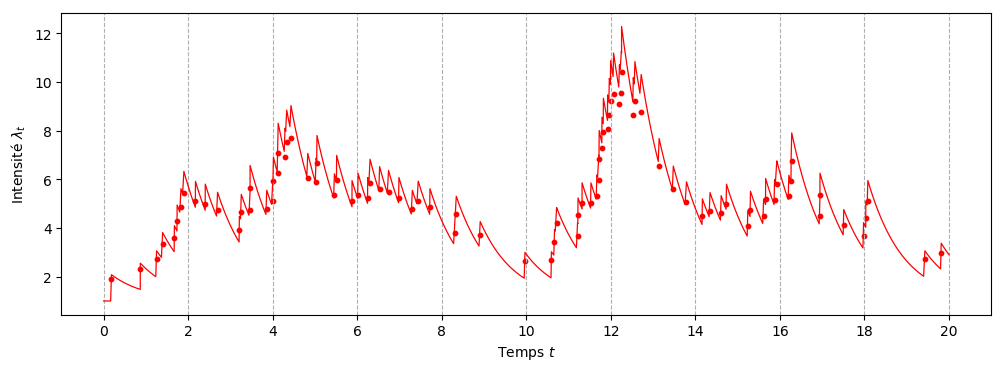

In [128]:
one_traj = sample_trajectories[1].numpy()
fig, ax = plt.subplots(1,1, figsize=(12,4), dpi=100)
ax.set_xlabel("Temps $t$")
ax.set_ylabel(r"Intensité $\lambda_t$")
t_arr = np.sort(np.append(np.linspace(0, tmax, 600), one_traj[:,0]))
ax.plot(t_arr, intensity_function(t_arr, mu, alpha, beta, one_traj[:,0]), 'r-', linewidth=0.9)
ax.xaxis.set_major_locator(mticker.MultipleLocator(2.))
scatter_opts = {
    "c": "r", "s": 11
}
ax.grid(True, axis='x', linestyle='--')
ax.scatter(one_traj[:,0], one_traj[:,1], c='r', s=10)

We will pad each sequence with 0s at the end.

In [132]:
data_tensor = nn.utils.rnn.pad_sequence(sample_trajectories).to(torch.float)
# Add a beginning-of-sequence event:
times_tensor = data_tensor[:,:,0]
times_tensor = torch.cat((torch.zeros(1,times_tensor.shape[1]), times_tensor), dim=0)

Text(0, 0.5, 'Number')

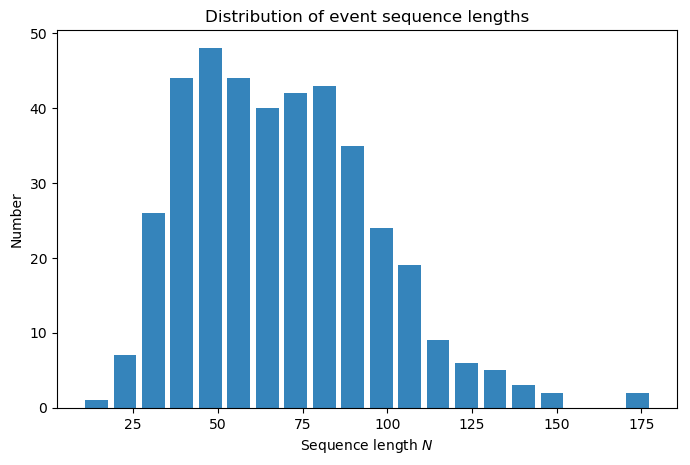

In [134]:
fig, ax = plt.subplots(1, 1, figsize=(8,5), dpi=100)
ax.hist(seq_lengths, bins=2*int(seq_lengths.size(0)**(2/5)), rwidth=0.8, alpha=0.9)
ax.set_title('Distribution of event sequence lengths')
ax.set_xlabel('Sequence length $N$')
ax.set_ylabel('Number')

In [135]:
data_tensor.shape

torch.Size([178, 400, 3])

The first dimension is for the sequence length, the second for the sample number.

# Neural network

We are going for a recurrent neural structure that can learn from previous events. The intensity process of our neural model will be of the form

$$
    \lambda_t = \phi\left(W_h h(t)\right)
$$

with $\phi$ a positive-valued activation function (such as ReLU) and $h(t)\in\mathbb R^D$ a continuous hidden state, computed as
\begin{equation}
    h(t) = h_{i-1}e^{-\delta_i(t-t_{i-1})},\quad \forall t\in(t_{i-1},t_i]
\end{equation}

The initial values $(h_i)$ are learned recursively by the network.

In [431]:
from torch import nn
import torch.nn.functional as F

In [432]:
from models.rnn import HawkesRNNModel

In [433]:
hidden_size = 12
model = HawkesRNNModel(hidden_size)

In [434]:
sequence = times_tensor[:,10]

In [435]:
optimizer = torch.optim.Adam(model.parameters())

In [436]:
def train(model: HawkesRNNModel, sequence: torch.Tensor, seq_length):
    """
    Args:
        seq_length: sequence length
    """
    # Trim the sequence to its real length
    sequence = sequence[:seq_length]
    # Reshape to a format the RNN can understand
    # N * batch * 1 (= feature dim)
    sequence = sequence.unsqueeze(1).unsqueeze(1)
    dt_sequence = sequence[1:] - sequence[:-1]
    # Data records
    hidd_decayed = model.initialize_hidden()
    hiddens = []
    decays = []
    for i in range(seq_length-1):
        hidd, dec, hidd_decayed = model(dt_sequence[i], hidd_decayed)
        hiddens.append(hidd)
        decays.append(dec)
    hiddens = torch.stack(hiddens)
    decays = torch.stack(decays)
    train_data = {
        "hidden": hiddens,
        "decay": decays
    }
    loss: Tensor = model.compute_loss(sequence, hiddens, decays, tmax)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()  # zero the gradients
    return train_data, loss.item()

In [437]:
sequence.unsqueeze(1).unsqueeze(1).shape

torch.Size([179, 1, 1])

In [438]:
# define training loop
train_size = 100
epochs = 8
loss_hist = []
for e in range(1, epochs+1):
    print("Epoch %d" % e)
    for i in range(train_size):
        sequence = times_tensor[:, i]
        train_info, loss = train(model, sequence, seq_lengths[i])
    loss_hist.append(loss)  # append the final loss of each epoch

Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8


Text(0, 0.5, 'Loss')

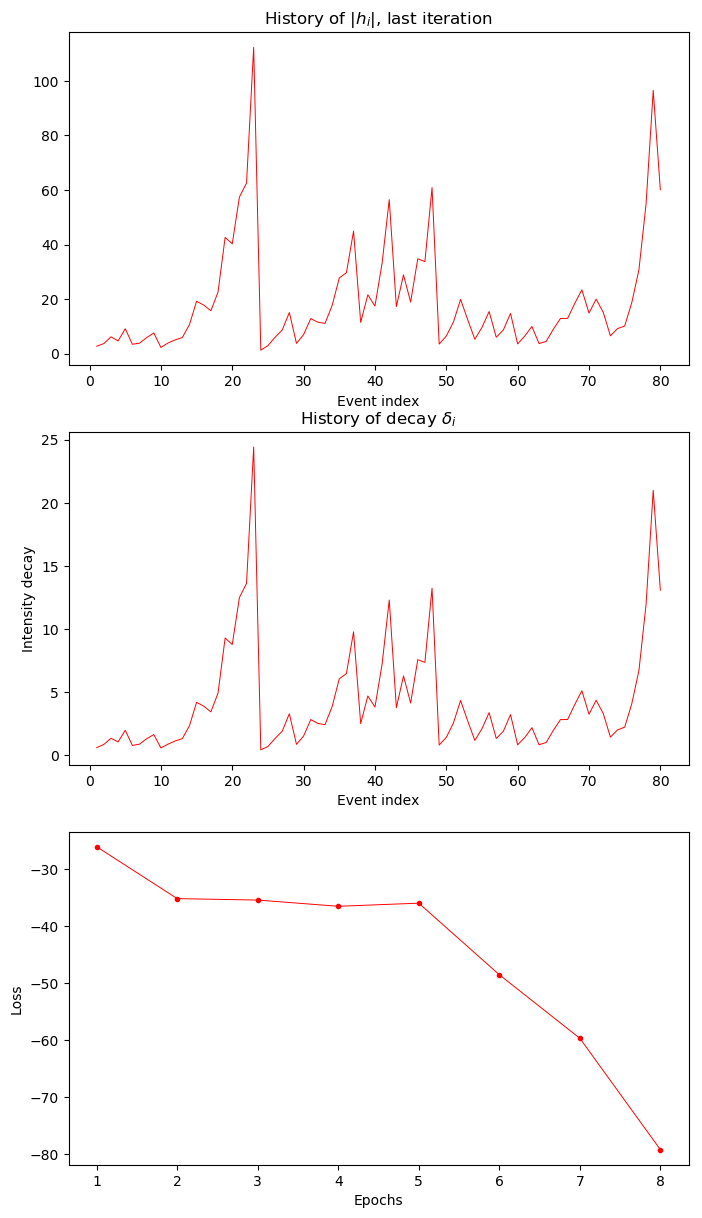

In [466]:
hidden_hist = train_info['hidden'].squeeze(1).squeeze(1)
decay_hist = train_info['decay'].squeeze(1).squeeze(1)
fig, (ax0, ax1, ax2) = plt.subplots(3,1, figsize=(8,15), dpi=100)
seq_index_range = list(range(1, 1+len(hidden_hist)))
ax0.plot(seq_index_range, hidden_hist.detach().norm(dim=1).numpy(), linewidth=.7, color='red')
ax0.set_title("History of $|h_i|$, last iteration")
ax0.set_xlabel("Event index")
ax1.plot(seq_index_range, decay_hist.detach().numpy(), linewidth=.7, color='red')
ax1.set_xlabel("Event index")
ax1.set_ylabel("Intensity decay")
ax1.set_title("History of decay $\delta_i$")
epochs_range = list(range(1, epochs+1))
ax2.plot(epochs_range, loss_hist, color='red',
         linewidth=.7, marker='.')
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Loss")

In [453]:
gen_event_times, gen_event_intens, gen_event_decay = model.generate_sequence(tmax)
print("generated %d events" % len(gen_event_times))
gen_event_times

max lbda tensor([[1.4673]])	time increment 0.14993330836296082	ratio 0.9364801049232483
max lbda tensor([[2.0478]])	time increment 0.6278782486915588	ratio 0.5617642998695374
max lbda tensor([[2.4360]])	time increment 0.31103453040122986	ratio 0.7183724045753479
max lbda tensor([[3.9895]])	time increment 0.07210630923509598	ratio 0.8858919143676758
max lbda tensor([[7.0985]])	time increment 0.7540532350540161	ratio 0.11651317030191422
max lbda tensor([[0.8271]])	time increment 2.7258546352386475	ratio 0.27953624725341797
max lbda tensor([[0.2312]])	time increment 6.504305362701416	ratio 0.9993605613708496
max lbda tensor([[0.6600]])	time increment 2.2492923736572266	ratio 0.4963385760784149
max lbda tensor([[0.9877]])	time increment 0.17338521778583527	ratio 0.9046574234962463
max lbda tensor([[3.2518]])	time increment 1.0203559398651123	ratio 0.2547054588794708
max lbda tensor([[1.5677]])	time increment 0.25686466693878174	ratio 0.8238372802734375
max lbda tensor([[3.1506]])	time incr

tensor([ 0.0000,  0.1499,  0.7778,  1.0888,  1.1610, 11.1452, 13.3945, 13.5678,
        14.5882, 14.8451, 15.3404, 19.9562])

In [318]:
def plot_events_and_intensity(event_times, event_intensities):
    fig, (ax0, ax1) = plt.subplots(2, 1, sharex=True,
                                   dpi=120,
                                   gridspec_kw = {'height_ratios':[3, 0.3]},
                                   figsize=(10,6))
    time_arr = np.linspace(0, tmax, 100)
    n_events = event_times.shape[0] - 1
    max_intens = max(event_intensities)
    min_intens = min(event_intensities)
    ax0.scatter(event_times[1:], event_intensities, s=8, alpha=0.7)
    ax0.set_ylabel("Event intensities $\lambda_t$")
    ax1.scatter(event_times[1:], [0.0 for _ in range(n_events)],
                alpha=0.4, s=16)
    ax1.set_xlabel("Time $t$")

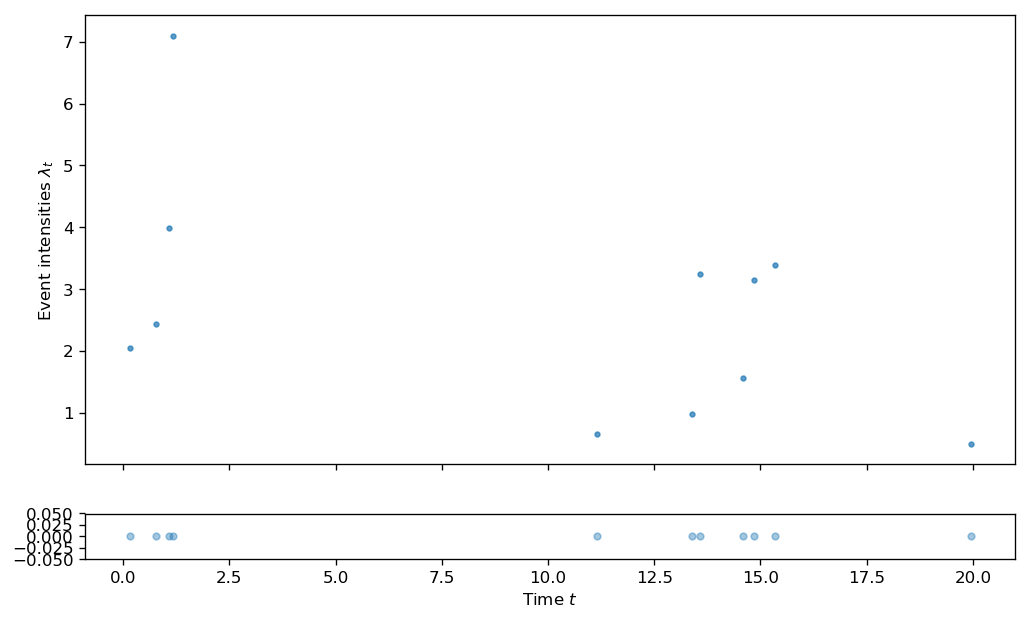

In [454]:
plot_events_and_intensity(gen_event_times, gen_event_intens)